In [17]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(".")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
from functools import partial
import itertools as it
from typing import Callable

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import lenses
import optax

In [19]:
from flox.jax_utils import key_chain


DIM = 4
NUM_AUX = 3
NUM_HIDDEN = 64
NUM_CONTROL_POINTS = 20
NUM_FLOW_LAYERS = 4
BATCH_SIZE = 128

seed = jax.random.PRNGKey(42)
chain = key_chain(seed)

In [20]:
from functools import partial
from typing import cast

import haiku as hk
from jaxtyping import Array, Float  # type: ignore
import numpy as np

from flox.flow_api import Coupling, Parameters, Sequential, Transformed, VolumeAccumulator
from flox.flow_impl import Affine, ConvexPotential
from flox.func_utils import pipe, compose2, pipe2
from flox.modules import LayerStack
from flox.quaternion import Quaternion


def dense(units, activation, name="dense"):
    layers = []
    with hk.experimental.name_scope(name):
        for idx, out in enumerate(units):
            layers.append(hk.Linear(out))
            if idx < len(units) -1:
                layers.append(activation)
    return hk.Sequential(layers, name=name)


class FlipSymmetricNet(hk.Module):

    def __init__(self, encoder_cstr: Callable, decoder_cstr: Callable):
        super().__init__()
        self.encoder = encoder_cstr(name="encoder")
        self.decoder = decoder_cstr(name="decoder")

    def __call__(self, p: Quaternion) -> Float[Array, "N"]:
        ypos = self.encoder(+p)
        yneg = self.encoder(-p)

        # make sure gradients flow 
        y = jnp.stack([ypos, yneg], axis=0)
        weight = jax.nn.softmax(y, axis=0)

        z = (weight * y).sum(0)

        return self.decoder(z)
        

class AffineParams(hk.Module):

    def __init__(self, net_cstr, num_dims: int, name="affine_params"):
        super().__init__(name=name)
        self.net = hk.Sequential([
            net_cstr(),
            hk.Linear(2 * num_dims, name="output")
        ], name="sequential")

    def __call__(self, p: Quaternion) -> Parameters:
        shift, scale = jnp.split(self.net(p), 2)
        return Parameters(shift=shift, scale=scale)


class ConvexPotentialParams(hk.Module):

    def __init__(self, net_cstr, num_control_points: int, num_dims: int, name="convex_potential_params"):
        super().__init__(name=name)
        self.net = hk.Sequential([
            net_cstr(),
            hk.Linear(
                num_control_points * num_dims
                + 2 * (num_control_points + 1),
                name="output"
            )
        ], name="sequential")
        self.num_control_points = num_control_points
        self.num_dims = num_dims
    
    def __call__(self, p):
        slices = np.cumsum([self.num_control_points * self.num_dims,self.num_control_points + 1])
        ctrlpts, weights, bias = jnp.split(self.net(p), slices)
        ctrlpts = ctrlpts.reshape(self.num_control_points, self.num_dims)
        return Parameters(
            ctrlpts=ctrlpts,
            weights=weights,
            bias=bias
        )


def make_flip_symmetric_net(num_hidden: int, num_out: int) -> FlipSymmetricNet:
    return FlipSymmetricNet(
        partial(dense, [num_hidden, num_hidden], jax.nn.silu),
        partial(dense, [num_hidden, num_out], jax.nn.silu)
    )


def make_flow():
    return Sequential(tuple(map(VolumeAccumulator, (
        Coupling(
            Affine,
            lenses.lens.quat.F(AffineParams(
                partial(make_flip_symmetric_net, NUM_HIDDEN, 2 * NUM_AUX),
                num_dims=NUM_AUX)),
            lenses.lens.aux
        ),
        Coupling(
            ConvexPotential,
            lenses.lens.aux.F(ConvexPotentialParams(
                partial(dense, [128, 64], jax.nn.tanh),
                num_control_points=NUM_CONTROL_POINTS,
                num_dims=DIM)),
            lenses.lens.quat
        ),
    ))))

@hk.without_apply_rng
@hk.multi_transform
def flow():

    def init(num_layers: int, input: Transformed[Array]):
        flow = LayerStack(make_flow, num_layers=num_layers)
        return pipe2(flow.forward, flow.inverse)(input)
    
    def forward(num_layers: int, input: Transformed[Array]):
        flow = LayerStack(make_flow, num_layers=num_layers)
        return flow.forward(input)
    
    def inverse(num_layers: int, input: Transformed[Array]):
        flow = LayerStack(make_flow, num_layers=num_layers)
        return flow.inverse(input)

    return init, (forward, inverse)

init = jax.jit(flow.init)
forward, inverse = flow.apply

In [21]:
from jax_dataclasses import pytree_dataclass
from flox.geometry import VectorN


@pytree_dataclass
class Node:
    quat: Quaternion
    aux: VectorN

In [22]:

from flox.euler import EulerAngles, from_euler
from flox.geometry import unit
from flox.quaternion import mat_to_quat


K = 2  # num clusters
std = 0.05  # cluster std
so3_only = True  # sample data only on SO(3) or on full S3?


def sample_mixture(key, means, stds):
    """ sample simple mixture model """
    chain = key_chain(key)
    samples = jax.random.normal(next(chain), shape=means.shape) * stds + means
    mixture = jax.random.choice(next(chain), jnp.arange(means.shape[0]))
    return samples[mixture]


def sample_target(key):
    """ sample target density on so(3) / s3 """
    chain = key_chain(key)
    angles = jnp.concatenate([
        sample_mixture(next(chain), jnp.linspace(0., 1., K, endpoint=False).reshape(-1, 1), std * jnp.ones(K).reshape(-1, 1)) *2 * jnp.pi,
        jnp.arccos(
            jnp.clip(sample_mixture(next(chain), jnp.linspace(-0.6, 0.6, K).reshape(-1, 1), std * jnp.ones(K).reshape(-1, 1)), -1., 1.)
        ),
        sample_mixture(next(chain), jnp.linspace(0., 1., K, endpoint=False).reshape(-1, 1), std * jnp.ones(K).reshape(-1, 1)) * 2* jnp.pi
    ])
    quat = mat_to_quat(from_euler(cast(EulerAngles, angles)))
    if not so3_only:
        quat = quat * jnp.where(jax.random.normal(next(chain), (1,)) > 0, 1., -1.)
    aux = jax.random.normal(next(chain), shape=(NUM_AUX,))
    return Transformed(Node(quat, aux), jnp.zeros(()))


def sample_uniform(key):
    """ uniform samples on so(3) / s3 """
    chain = key_chain(key)
    quat = unit(jax.random.normal(next(chain), shape=(DIM,)))    
    aux = jax.random.normal(next(chain), shape=(NUM_AUX,))
    return Transformed(Node(quat, aux), jnp.zeros(()))


# sample_flow = pipe2(sample_uniform, partial(inverse, params, NUM_FLOW_LAYERS))

In [23]:
sample_flow_ = jax.jit(jax.vmap(lambda params, key: inverse(params, NUM_FLOW_LAYERS, sample_uniform(key)), in_axes=(None, 0)))
sample_target_ = jax.jit(jax.vmap(sample_target))

In [24]:
def plot_flow(key: jax.random.PRNGKeyArray, params, log_norm: bool = False, savefile: str | None = None):

    if log_norm:
        norm = LogNorm()
    else:
        norm = None
        
    chain = key_chain(key)
        
    N = int(1/2 * (DIM-1) * (DIM ))
    
    target_samples = sample_target_(jax.random.split(next(chain), 10000)).payload
    flow_samples = sample_flow_(params, jax.random.split(next(chain), 10000)).payload

    plt.figure(figsize=(8, 4 * N))
    for k, ((i, j)) in enumerate(it.combinations(range(DIM), r=2), start=1):

        ax = plt.subplot(N, 2, 2 * k - 1)

        plt.title(f"data: {i},{j}")
        plt.hist2d(*target_samples.quat[:, (i, j)].T, bins=50, norm=norm, range=((-1.05, 1.05), (-1.05, 1.05)))
        ax.set_facecolor('xkcd:salmon')

        plt.xlim(-1.1, 1.1)
        plt.ylim(-1.1, 1.1)
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()

        ax = plt.subplot(N, 2, 2 * k)
        plt.title(f"flow: {i},{j}")
        plt.hist2d(*flow_samples.quat[:, (i, j)].T, bins=50, norm=norm, range=((-1.05, 1.05), (-1.05, 1.05)))
        ax.set_facecolor('xkcd:salmon')

        plt.xlim(-1.1, 1.1)
        plt.ylim(-1.1, 1.1)
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()

    if savefile is not None:
        plt.savefig(savefile)

In [25]:
from flox.geometry import Scalar


def objective(key, params) -> Scalar:
    chain = key_chain(key)
    key = jax.random.split(key, BATCH_SIZE)
    inp = jax.vmap(sample_target)(key)
    out = jax.vmap(forward, in_axes=(None, None, 0))(params, NUM_FLOW_LAYERS, inp)
    return (
        0.5 * jnp.square(out.payload.aux).sum(axis=-1)
        - out.logprob
    ).mean()

@partial(jax.jit, static_argnames=("optim"))
def step(key, params, optim, opt_state):
    chain = key_chain(key)
    loss, grads = jax.value_and_grad(objective, argnums=1)(next(chain), params)
    updates, opt_state = optim.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

In [10]:
initial = Transformed(Node(jnp.empty((DIM,), jnp.float32), jnp.empty((NUM_AUX,), jnp.float32)), jnp.empty(()))
params = flow.init(next(chain), NUM_FLOW_LAYERS, initial)

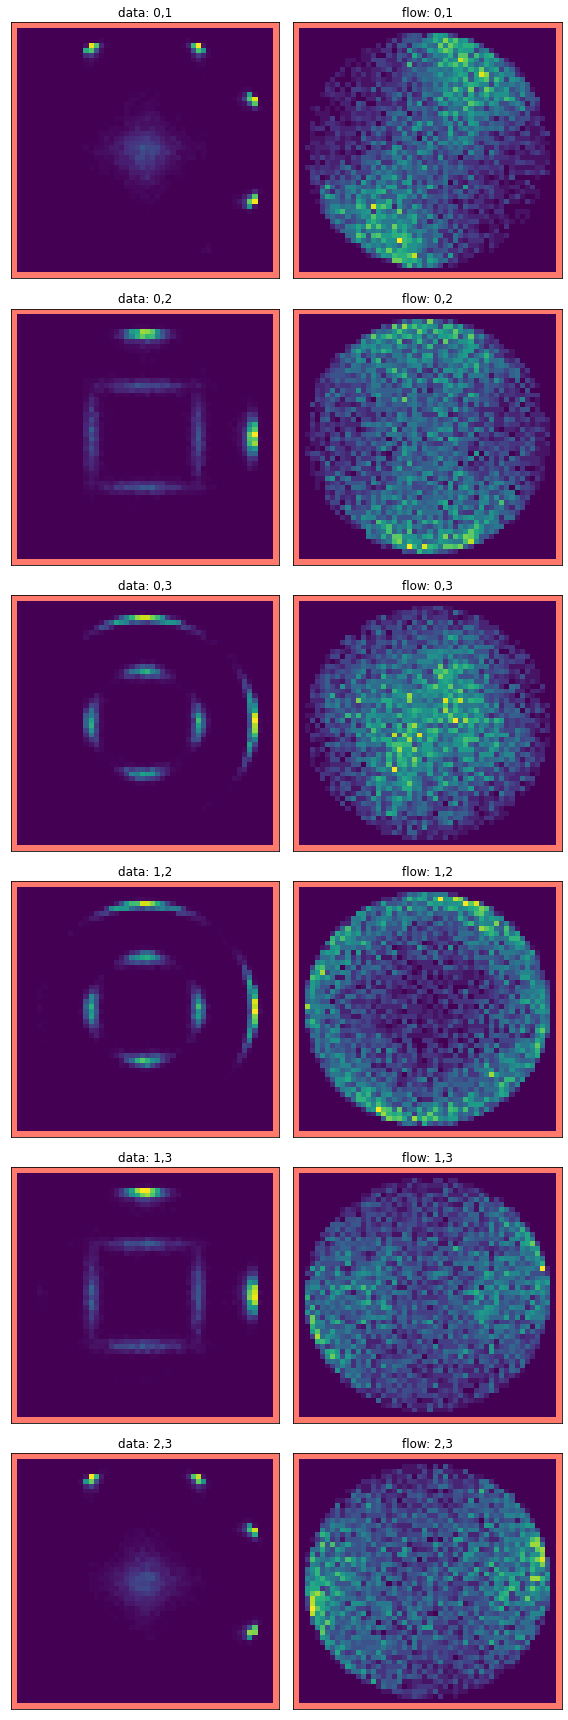

In [11]:
plot_flow(next(chain), params)

In [12]:
learning_rate = 5e-4
optim = optax.adam(learning_rate)
opt_state = optim.init(params)

In [15]:
num_iters = 5_000
print_period = 1_000

for i in range(num_iters):
    loss, params, opt_state = step(next(chain), params, optim, opt_state)
    if not i % print_period:
        print(f"iter: {i}/{num_iters}: nll: {loss:.4}")

iter: 0/5000: nll: -1.606
iter: 1000/5000: nll: 3.533
iter: 2000/5000: nll: -1.033
iter: 3000/5000: nll: -1.48
iter: 4000/5000: nll: -1.531


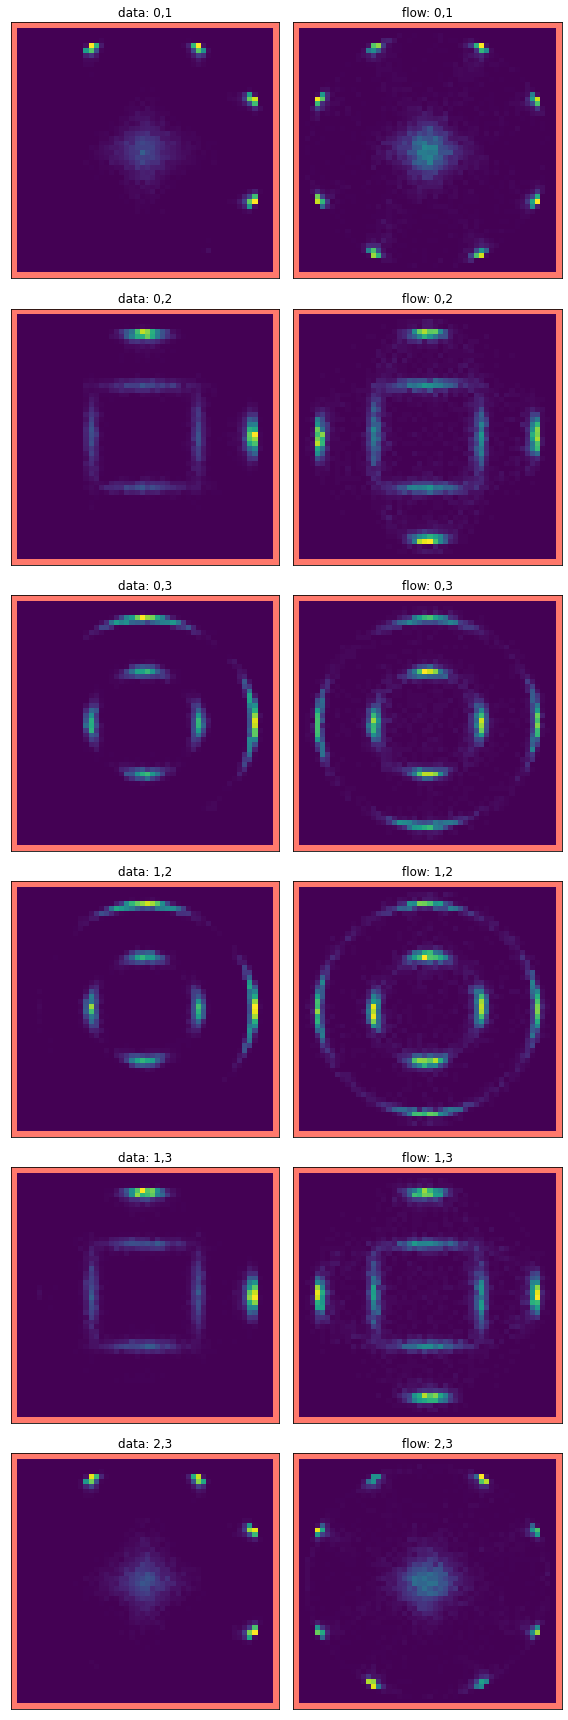

In [16]:
plot_flow(next(chain), params)